In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import clear_output, display, HTML
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# This line is a work around for an error when viewing dataframes
#get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""

In [10]:
import pandas as pd
#from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
df=pd.read_csv(r'data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')

classes = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']
groupwise = []
y=np.argmax(df[classes].to_numpy(),axis=1)
print(y[:10])
w = compute_class_weight(class_weight='balanced',classes=np.unique(y),y=y)
print(w)
for class_ in classes:
    groupwise.append(df[df[class_]==1.0])
for name,group in zip(classes,groupwise):
    print(name,':',len(group))
    
np.random.seed(50)
train = None
test = None
validate = None
for g in groupwise:
    tr,te,va = np.split(g, [int(.95*len(g)), int(.96*len(g))])
    #print(tr)
    if train is not None:
        train =train.append(tr)
    else:
        train = tr
    if test is not None:
        test = test.append(te)
    else:
        test = te
    if validate is not None:
        validate = validate.append(va)
    else:
        validate = va

train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)
validate = validate.sample(frac=1).reset_index(drop=True)
        
print('train count:',len(train))
print('train:\n',train.head())
print('test count:',len(test))
print('test:\n',test.head())
print('validate count',len(validate))
print('validate:\n',validate.head())

[1 1 1 1 0 1 4 0 1 0]
[ 1.285458  0.21338   2.783491  4.375273  1.301833 12.440994 10.075453]
MEL : 1113
NV : 6705
BCC : 514
AKIEC : 327
BKL : 1099
DF : 115
VASC : 142
train count: 9511
train:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0031583  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0025666  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0027174  1.0  0.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0029955  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0026651  0.0  1.0  0.0    0.0  0.0  0.0   0.0
test count: 100
test:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0033861  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0033826  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0033822  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0033825  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0033839  0.0  1.0  0.0    0.0  0.0  0.0   0.0
validate count 404
validate:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0034090  0.0  1.0  0.0    0.0  0.0  0.0   0

In [11]:
df = df.sample(frac=1).reset_index(drop=True)
print('total count:',len(df))
print('a few samples from csv:\n',df.head())

total count: 10015
a few samples from csv:
           image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0030972  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0029180  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0028105  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0027406  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0025111  0.0  1.0  0.0    0.0  0.0  0.0   0.0


In [12]:
data = ImageDataBunch.from_df(path='data', ds_tfms=get_transforms(), df=df,size=128, bs=128, suffix='.jpg', 
                               folder='ISIC2018_Task3_Training_Input', fn_col='image',label_col=classes,
                               valid_pct=0.05,test='ISIC2018_Task3_Test_Input').normalize(imagenet_stats)

In [15]:
def getLearner():
    return cnn_learner(data, models.densenet121, pretrained=True, metrics=error_rate,
                      callback_fns=ShowGraph)

learner = getLearner()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /home/user1/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [16]:
# Code below is to find best weight decay rate

lrs = []
losses = []
wds = []
iter_count = 600

# WEIGHT DECAY = 1e-6
learner.lr_find(wd=1e-6, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-6')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-4
learner.lr_find(wd=1e-4, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-4')
learner = getLearner() #reset learner - this gets more consistent starting conditions

# WEIGHT DECAY = 1e-2
learner.lr_find(wd=1e-2, num_it=iter_count)
lrs.append(learner.recorder.lrs)
losses.append(learner.recorder.losses)
wds.append('1e-2')
learner = getLearner() #reset learner

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


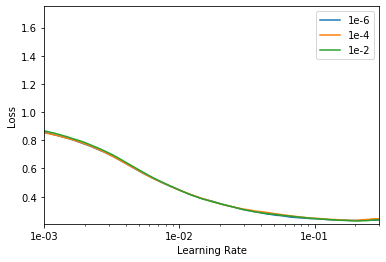

In [17]:
# Plot weight decays
_, ax = plt.subplots(1,1)
min_y = 0.8
max_y = 1.75
for i in range(len(losses)):
    ax.plot(lrs[i], losses[i])
    min_y = min(np.asarray(losses[i]).min(), min_y)
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale('log')
#ax ranges may need some tuning with different model architectures 
ax.set_xlim((1e-3,3e-1))
ax.set_ylim((min_y - 0.02,max_y))
ax.legend(wds)
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))

In [18]:
max_lr = slice(3e-3,3e-2)
wd = 1e-2

epoch,train_loss,valid_loss,error_rate,time
0,0.410141,0.190535,0.785143,00:23
1,0.213872,0.163356,0.716571,00:21
2,0.159262,0.136911,0.820857,00:22
3,0.134152,0.119936,0.811714,00:22
4,0.119889,0.113739,0.843429,00:22
5,0.103401,0.111810,0.845143,00:22
6,0.084927,0.100570,0.824571,00:22
7,0.073211,0.100864,0.819429,00:22


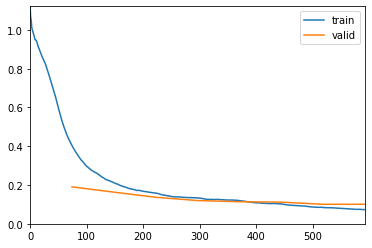

In [19]:
learner.fit_one_cycle(cyc_len=8, 
                      max_lr=max_lr, 
                      wd=wd)

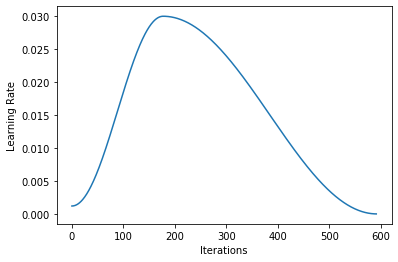

In [20]:
learner.recorder.plot_lr()

In [21]:
learner.save('densenet121_wd_128_fit1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


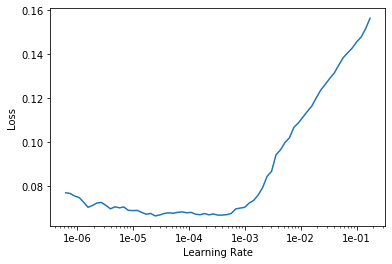

In [22]:
# load the baseline model
learner.load('densenet121_wd_128_fit1')

# unfreeze and run learning rate finder again
learner.unfreeze()
learner.lr_find(wd=wd)

# plot learning rate finder results
learner.recorder.plot()

epoch,train_loss,valid_loss,error_rate,time
0,0.066595,0.098882,0.827429,00:26
1,0.067196,0.097125,0.836857,00:26
2,0.065739,0.097513,0.833714,00:26
3,0.062470,0.114564,0.840000,00:26
4,0.055503,0.100543,0.819143,00:26
5,0.048878,0.108817,0.823143,00:26
6,0.041578,0.094799,0.814571,00:26
7,0.034015,0.096250,0.824286,00:26
8,0.027999,0.094759,0.815143,00:26
9,0.023410,0.092466,0.807429,00:26


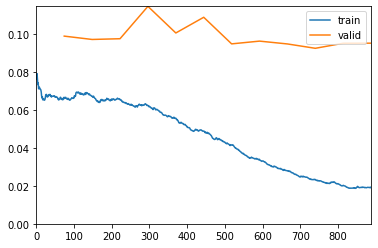

In [23]:
# Entered unintended learning rates here
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))
#learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.018157,0.100414,0.814857,00:26
1,0.020781,0.097074,0.810571,00:26
2,0.024736,0.107402,0.791429,00:26
3,0.028276,0.114705,0.822571,00:26
4,0.025497,0.114001,0.826571,00:26
5,0.023572,0.107355,0.820000,00:26
6,0.020348,0.136678,0.832571,00:26
7,0.015244,0.104081,0.821714,00:26
8,0.012151,0.111359,0.821429,00:26
9,0.009858,0.108884,0.813714,00:26


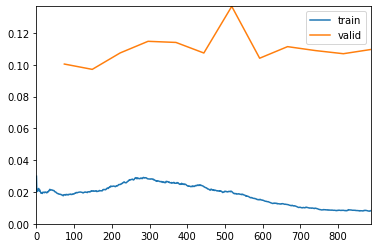

In [24]:
# Entered unintended learning rates here
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))
#learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.007596,0.107956,0.822000,00:26
1,0.008183,0.124671,0.810000,00:26
2,0.016014,0.140933,0.821714,00:26
3,0.018678,0.115033,0.818000,00:26
4,0.016798,0.120659,0.798286,00:26
5,0.015458,0.106486,0.816000,00:26
6,0.013739,0.117728,0.819143,00:26
7,0.010689,0.105264,0.821429,00:26
8,0.006835,0.111034,0.811429,00:26
9,0.005893,0.112871,0.822000,00:26


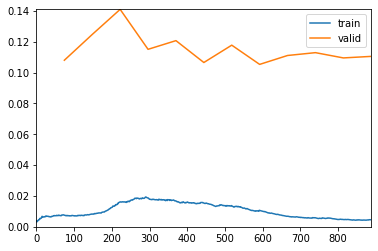

In [29]:
# Entered unintended learning rates here
learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))
#learner.fit_one_cycle(cyc_len=12, max_lr=slice(4e-5,4e-4))

In [33]:
learner.save('desnsenet151_128_wd_not_better')

In [36]:
learner.save('desnsenet151_128_wd_not_better2')

In [39]:
learner.load('desnsenet151_128_wd_not_better')

Learner(data=ImageDataBunch;

Train: LabelList (9515 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
NV,NV,NV,NV,NV
Path: data;

Valid: LabelList (500 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: MultiCategoryList
NV,NV,NV,BKL,MEL
Path: data;

Test: LabelList (1512 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
     

epoch,train_loss,valid_loss,error_rate,time
0,0.004675,0.108622,0.813143,00:26
1,0.004750,0.108332,0.814286,00:26
2,0.004677,0.106803,0.815429,00:26
3,0.003886,0.104888,0.816286,00:26
4,0.003622,0.108754,0.820000,00:26
5,0.003460,0.107378,0.818000,00:26
6,0.003667,0.108575,0.817714,00:26
7,0.003854,0.104667,0.814286,00:26


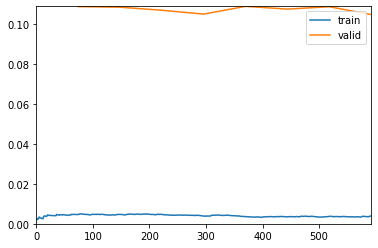

In [34]:
# Fixed learning rate here which proved to have the lowest error rate and best balance between train and val losses
learner.fit_one_cycle(cyc_len=8, max_lr=slice(7e-6,6e-5))

In [19]:
#interp = ClassificationInterpretation.from_learner(learner)

In [2]:
#interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

In [ ]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

val_preds,val_y = learner.TTA(ds_type=DatasetType.Valid)
val_preds,val_y = np.argmax(val_preds,axis=1),np.argmax(val_y,axis=1)
bas = balanced_accuracy_score(val_y,val_preds)
print(bas)


cm=confusion_matrix(val_y,val_preds)
print(cm)

cr=classification_report(val_y,val_preds)
print(cr)

In [48]:
np.set_printoptions(suppress=True)
preds, _ = learner.get_preds(ds_type=DatasetType.Test)
labels = preds.numpy()
test_index = []
num = len(learner.data.test_ds)
for i in range(num):
    test_index.append(str(learner.data.test_ds.items[i]).split('/')[-1])
df_test = pd.DataFrame(labels,columns=classes)

In [49]:
df_test.insert(0,'image',test_index)
print(df_test.head())

              image       MEL        NV           BCC         AKIEC  \
0  ISIC_0035868.jpg  0.001528  0.999119  1.092802e-06  6.631381e-06   
1  ISIC_0035930.jpg  0.011777  0.984750  4.864311e-04  3.507536e-04   
2  ISIC_0035542.jpg  0.000020  0.999997  1.405985e-08  5.191338e-07   
3  ISIC_0035123.jpg  0.007825  0.993564  5.141847e-06  6.638552e-04   
4  ISIC_0035684.jpg  0.000331  0.999929  1.842215e-06  3.040072e-07   

            BKL            DF          VASC  
0  6.225006e-06  4.482449e-08  6.662771e-07  
1  7.081395e-04  6.619023e-06  2.952509e-05  
2  8.000709e-07  2.073361e-09  8.737438e-09  
3  2.086052e-04  1.502090e-04  5.139450e-06  
4  1.911818e-06  1.091192e-06  1.478996e-07  


In [50]:
df_test.to_csv('test_results_for_submission.csv',index=False)

In [ ]:
learner.export("trained_model.pkl")

In [8]:
learner = load_learner('data','trained_model.pkl')